In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
sns.set_palette("Paired")

# COURS Stochastic Gradient Descent

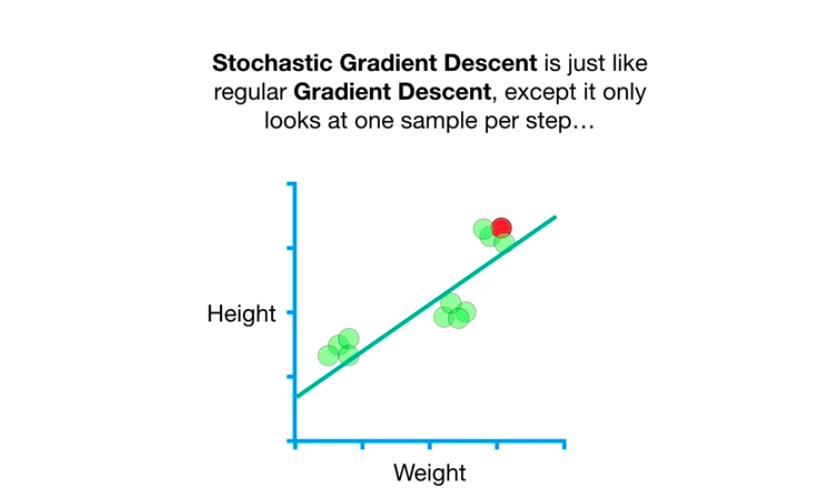

**Stochastic Gradient descent :**
- Manière de faire la descente de gradient en limitant le nombre de données sur lesquelles faire les calculs de dérivée de la fonction de perte à chaque étape (car une dérivée partielle par feature et par ligne du DF, le tout multiplié par le nombre de pas ça fait vite beaucoup trop).
- Stochastic pur : on prend aléatoirement une seule données à chaque itération
- Mini batch : on prend un petit échantillon des données à chaque itération, pour ménager la chèvre et le chou :
    - permet de gagner en rapidité par rapport au "classique", qui s'appelle aussi full batch
    - tout en étant malgré tout assez stable sur l'estimation des paramètres en un nombre de pas limités (tout comme le full batch)
- La SGD permet aussi de réajuster sans coût le modèle à l'arrivée d'une nouvelle donnée : on n'a qu'à l'intégrer sur la prochaine itération, sans repartir de 0 sur le modèle.

# Documentation 
http://archive.ics.uci.edu/ml/datasets/Adult

**Objectif : prédire si quelqu'un gagne plus ou moins de 50K à l'année** 

- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **fnlwgt**: continuous.
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.



# Premier nettoyage des données :
## Comprendre la structure du dataframe
- **Education et education-num** ==> supprimer une des deux car donnent les mêmes informations. Education-num correspond au niveau de formation (va de 1 pour pre-school à 16 pour PHD). A conserver
- **Final weight(fnlwgt)** ==> people with similar demographical caracteristic should have similar weight (if they are within the same state). Prend en compte la race, l'age et le sex (+origine hispanique). Attention les règles d'encodage diffèrent selon les états.
- **capital-gain et capital-loss** : revenus du patrimoine. Conserver les 0, mais peut-être regrouper les 2 en une colonne.



In [2]:
# import CSV + define cols names
col_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]
data = pd.read_csv("adult.data", names=col_names)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
data.duplicated().sum()

24

In [4]:
# pas de données manquantes enregistrées en tant que telles
# si on regarde de plus près, on voit des 0 dans le DF.  
# Ainsi que des points d'interrogation dont il faudra se préoccuper.
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

In [5]:
# Mais on a des 0, on regarde plus pércisément où ils sont.
nulls = data.values == 0
nulls.sum()
nulls2 = data[["capital-loss", "capital-gain"]].values == 0
nulls2.sum()
(data["capital-loss"].values == 0).sum()

31042

In [6]:
# on regarde le nombre de valeurs uniques sur certaines colonnes
data["native-country"].nunique()

42

In [7]:
# On cherche à comprendre la colonne "education-num" et son lien avec la colonne éducation. 
# On en conclut qu'elles procurent la même information.
data[data["education-num"].values == 15]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
52,47,Private,51835,Prof-school,15,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,1902,60,Honduras,>50K
111,38,Private,65324,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
234,28,Private,76714,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,55,United-States,>50K
250,41,Private,112763,Prof-school,15,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,>50K
286,41,Private,220531,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32258,51,Self-emp-inc,28765,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K
32370,53,Self-emp-not-inc,137547,Prof-school,15,Never-married,Prof-specialty,Not-in-family,Asian-Pac-Islander,Male,27828,0,40,Philippines,>50K
32436,37,Private,40955,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K
32466,37,Private,121521,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,15024,0,45,United-States,>50K


In [8]:
# On s'intéresse à la colonne "race", en vue de comprendre l'intérêt de la colonne fnlwgt
data["race"].value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

## Points d'interrogation, caractères spéciaux et encodage de la target

In [9]:
# avant toute modification, on fait une copie de notre dataset
df = data.copy()
df.shape

(32561, 15)

In [11]:
# quelles colonnes contiennent des points d'interrogation ?
interrogation = [col for col in df.columns if np.any(df[col]==" ?")]
print(f"colonnes concernées ==> {interrogation}")

# combien d'occurences de ? sur les colonnes concernées ?
for col in interrogation:
    inter = df[col]=="?"
    inter.sum()
    print(f"{col}==> {inter.sum()} valeurs trouvées")


colonnes concernées ==> []


In [10]:
# utilisation du regex pour supprimer espaces de chaque côté
df = df.replace('(^\s+|\s+$)', '', regex=True)

In [12]:
# on remplace les points d'interrogation par des NaN
df = df.replace({"?" : np.nan})
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
salary               0
dtype: int64

In [14]:
# on supprime les 24 doublons
df = df.drop_duplicates()

In [59]:
# on encode la target
#df["salary"] = df["salary"].replace({"<=50K" : 0, ">50K" : 1})
df["salary"].value_counts()
# Sur 32561 données, on a seulement 23% d'individus gagnant plus de 50K. 

<=50K    24698
>50K      7680
Name: salary, dtype: int64

# Data Exploratory Analysis

In [15]:
# on sépare les features numériques et catégoriels
features = df.drop("salary", axis=1)
target = df["salary"]
categorical_features_list = [col for col in features.columns if features[col].dtype == "object"]
numerical_features_list = [col for col in features.columns if features[col].dtype != "object"]
numerical = df[numerical_features_list]
categorical = df[categorical_features_list]

## Variables numériques

Première étape : encoder la target

In [16]:
# création d'une nouvelle colonne qui regroupe les deux infos
# finalement on ne la retiendra pas après visualisation des corrélations
#df["capital"] = df["capital-gain"]-df["capital-loss"]
#df["capital"]

In [17]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [18]:
# on regarde les corrélations entre les valeurs numériques
corr = df.corr(method="pearson")
corr

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076447,0.036224,0.077676,0.057745,0.068515
fnlwgt,-0.076447,1.000000,-0.043388,0.000429,-0.010260,-0.018898
education-num,0.036224,-0.043388,1.000000,0.122664,0.079892,0.148422
capital-gain,0.077676,0.000429,0.122664,1.000000,-0.031639,0.078408
capital-loss,0.057745,-0.010260,0.079892,-0.031639,1.000000,0.054229
hours-per-week,0.068515,-0.018898,0.148422,0.078408,0.054229,1.000000


**Conclusions sur nos variables** : 
- Supprimer fnlwgt
- créer une colonne combinant capital loss et gain ==> pas très concluant niveau corrélation

- supprimer les features inutiles
- encoder les variables catégorielles (discrétiser puis faire les corrélations dessus)

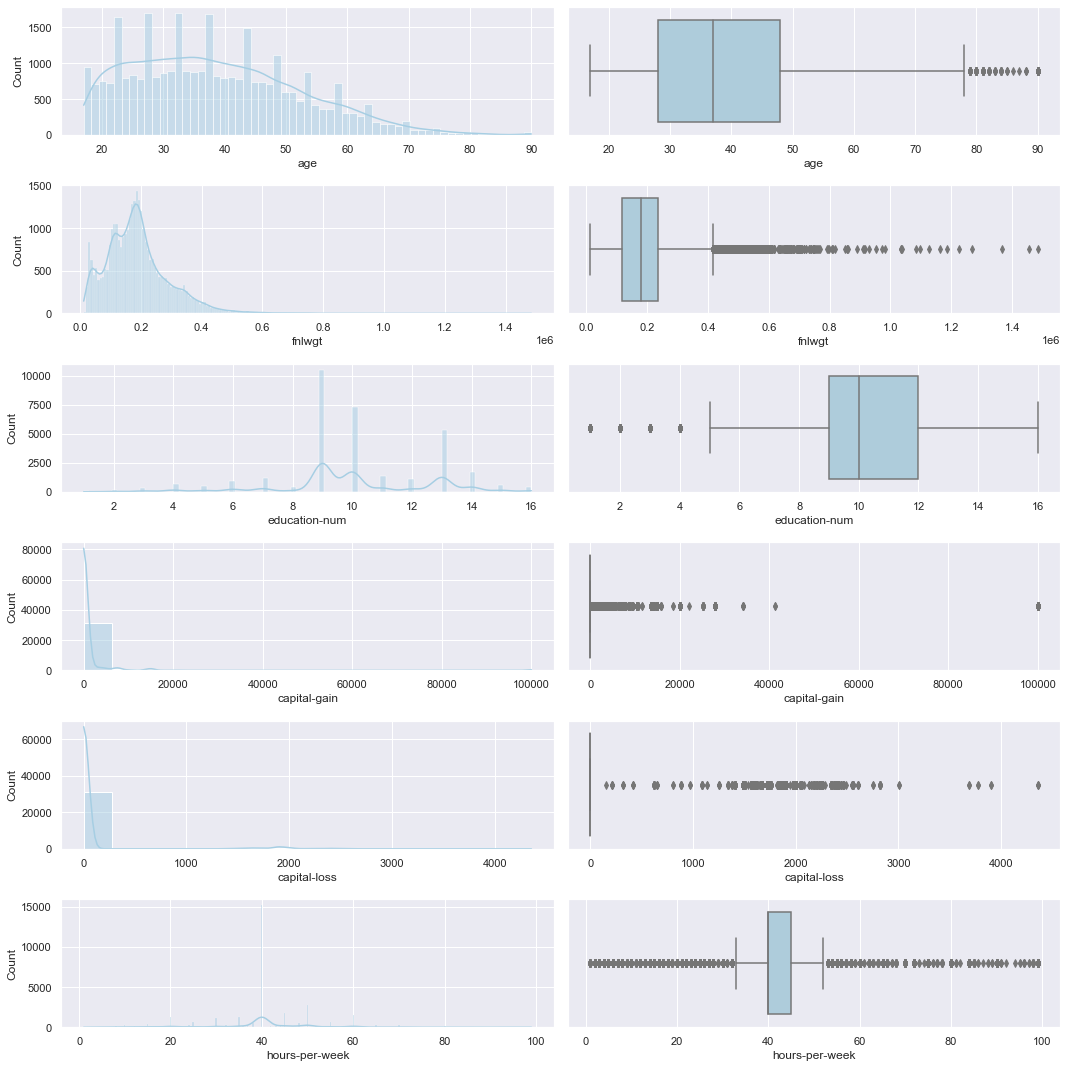

In [20]:
#swarmplot

def plot_numeric_features(df, numerical_features_list):
    import seaborn as sns
    import matplotlib.pyplot as plt
    #sns.set()  # Setting seaborn as default style even if use only matplotlib
    #sns.set_palette("Paired")  # set color palette
    fig, axes = plt.subplots(nrows=len(numerical_features_list),
                             ncols=2,
                             figsize=(15, 15))
    for i, feature in enumerate(numerical_features_list):
        sns.histplot(data=df, x=feature, kde=True, ax=axes[i, 0])
        sns.boxplot(data=df, x=feature, ax=axes[i, 1])
    plt.tight_layout()
    plt.show()


plot_numeric_features(df, numerical_features_list)

<AxesSubplot:xlabel='age', ylabel='Count'>

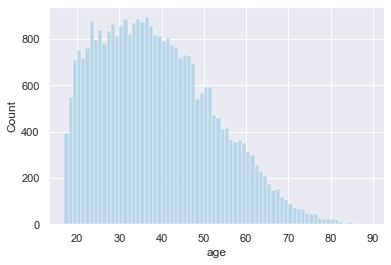

In [58]:
# Focus sur l'âge. 
sns.histplot(data=df, x="age", bins=[i for i in range(17,90,1)])

- **Age** : on observe des pics réguliers. A vérifier car peuvent correspondre à des personnes donnant leur âge arrondi (25 au lieu de 23 par exemple). Si c'est le cas peut-être passer cette colonne en classes d'âges. En vérifiant on se rend compte que c'est à cause de la façon dont sont calculés les bins que ces pics apparaissent. Si on met un bin par année on n'observe plus de pic. On peut donc conserver les données.
- **Hours per week** : le minimum est de 1 ce qui est étonnant car des individus ne travaillent probablement pas. Beaucoup d'outliers identifiés au-delà de 35-50, peu de personnes sont 
- **Capital-Gain** : outlier de 999999 à supprimer 

<br><br> **Modifications à faire** :
- Faire des classes d'âges
- Supprimer outlier de Capital-Gain
- 

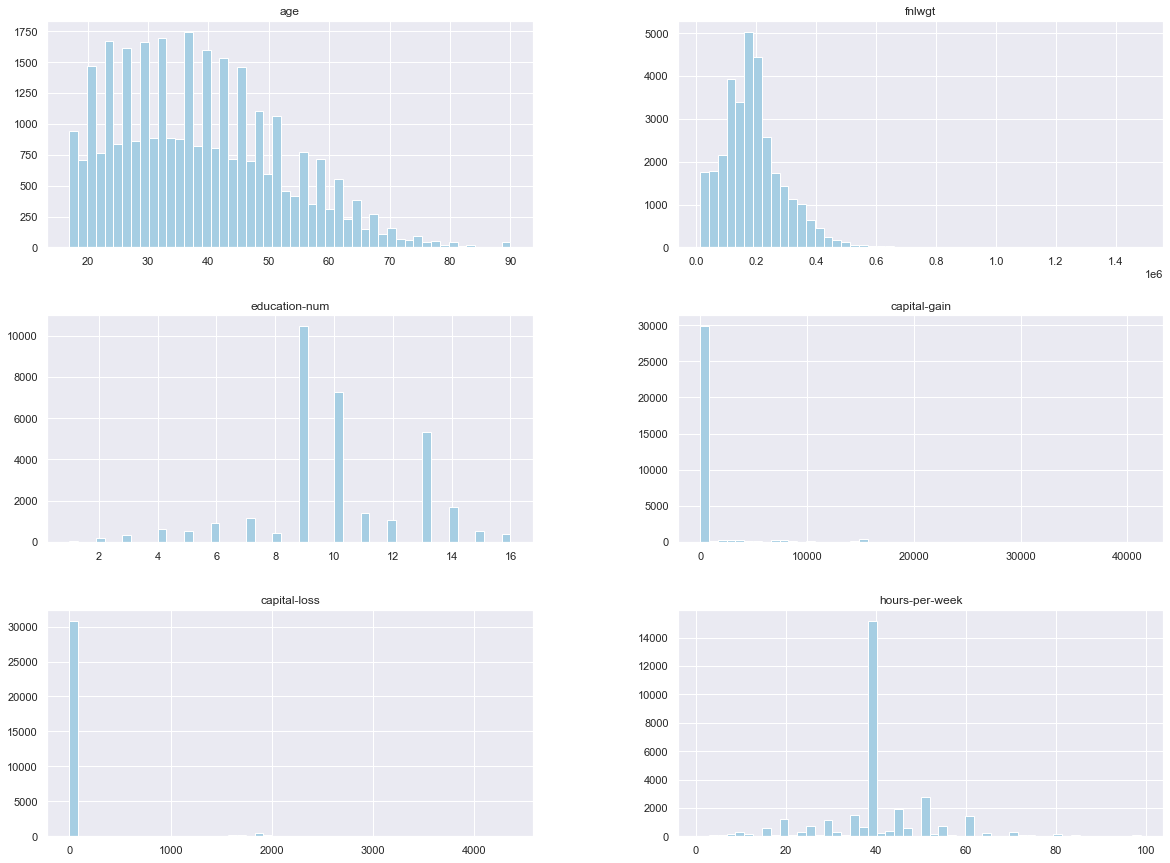

In [57]:
df.hist(bins=50, figsize=(20,15))
plt.show()

## Variables catégorielles

In [23]:
df["workclass"].value_counts()

Private             22673
Self-emp-not-inc     2540
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

<AxesSubplot:xlabel='education', ylabel='Count'>

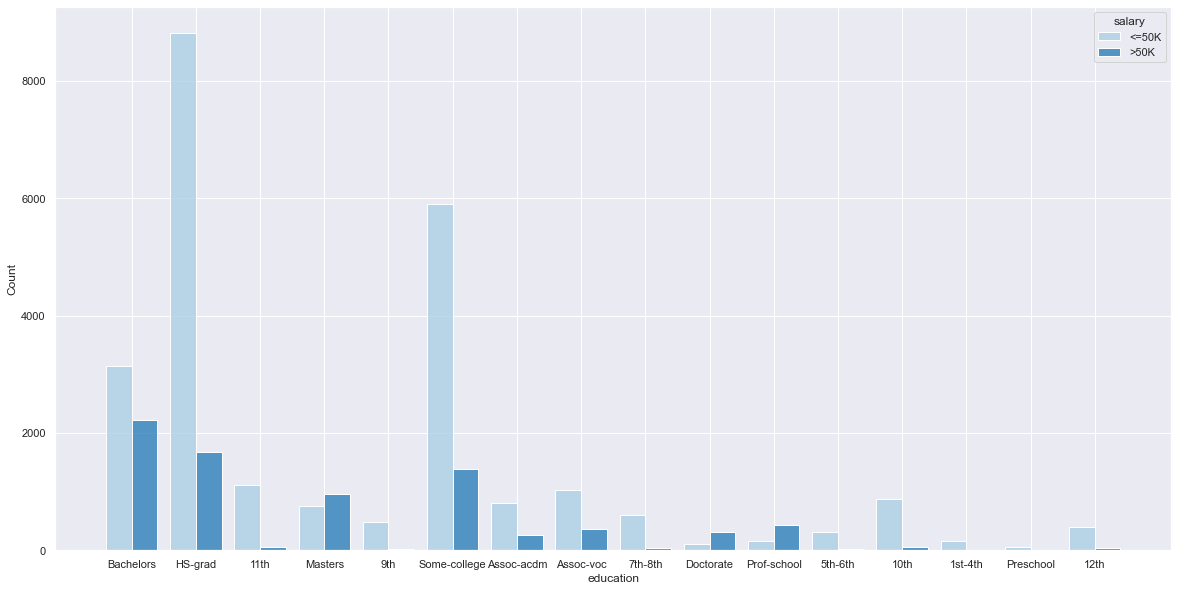

In [24]:
plt.figure(figsize = (20,10))
sns.histplot(data=df, x="education", hue="salary", multiple="dodge", shrink=.8)

<AxesSubplot:xlabel='sex', ylabel='Count'>

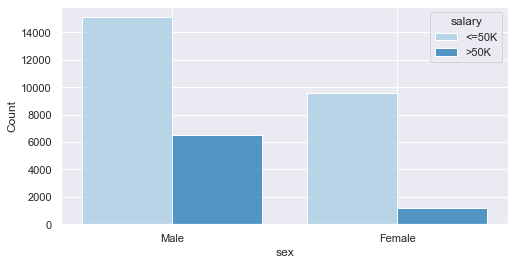

In [62]:
plt.figure(figsize = (8,4))
sns.histplot(data=df, x="sex", hue="salary", multiple="dodge", shrink=.8)

<AxesSubplot:xlabel='salary', ylabel='count'>

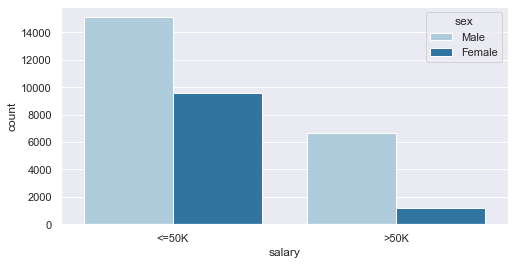

In [26]:
plt.figure(figsize = (8,4))
sns.countplot(data = df, x = 'salary', hue = 'sex')

## Modèle

### Suppression de l'outlier

In [27]:
# suppression de l'outlier
df = df[df["capital-gain"] < 99000]
df.shape

(32378, 15)

### Suppression de certains features
- fnlwgt (non significatif)
- education (multicolinéarité avec education-num

In [28]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

In [29]:
# drop education
df = df.drop("education", axis=1)

### Définition des X et y, train-test split

In [30]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'salary'],
      dtype='object')

### Préprocessing

#### Préprocessing sur les variables catégorielles ==> dataset en entier

In [31]:
# Import des bibliothèques 

from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict


In [32]:
X = df.drop("salary", axis=1)
y = df["salary"]

In [33]:
X["workclass"].value_counts()

Private             22591
Self-emp-not-inc     2511
Local-gov            2087
State-gov            1297
Self-emp-inc         1080
Federal-gov           959
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [34]:
# remplacement des valeurs nulles pour les variables catégorielles
categ_imputer = SimpleImputer(strategy="most_frequent")
X_imputed = categ_imputer.fit_transform(X)
# encodage des valeurs catégorielles
categ_encoder = OneHotEncoder()
X_categ_prepro = categ_encoder.fit_transform(X_imputed)

#### Train test split puis préprocessing sur variables numériques

In [35]:

X_train, X_test, y_train, y_test = train_test_split(X_categ_prepro, y, test_size=0.2, random_state=42)

In [36]:
# remplacement des valeurs nulles pour les variables numériques (X_train)
num_imputer = SimpleImputer(strategy="median")
X_train_imputed = num_imputer.fit_transform(X_train)
# standardisation
num_stand = StandardScaler(with_mean=False)
X_train_prepro = num_stand.fit_transform(X_train_imputed) 

### Modèle

In [37]:
model_1 = SGDClassifier()
model_1.fit(X_train_prepro, y_train)

SGDClassifier()

In [38]:
acc = cross_val_score(model_1, X_train_prepro, y_train)
acc.mean()

0.8309398239334544

### Amélioration des hyperparamètres avec GridSearchCV

In [44]:
max_iter = np.ceil(10**6 / X_train.shape[0])
max_iter

39.0

In [40]:
model_1.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [51]:
params = {"alpha": 10.0**-(np.arange(1,7)),
          "early_stopping" : [True, False],
          "max_iter" : [10000, 15000],
          "loss" : ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
         "penalty" : ["l1", "l2", "elasticnet"]}
search = GridSearchCV(model_1, params, cv=3,  scoring="accuracy")# scoring="recall"
search.fit(X_train_prepro, y_train)

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning:

GridSearchCV(cv=3, estimator=SGDClassifier(),
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'early_stopping': [True, False],
                         'loss': ['hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron'],
                         'max_iter': [10000, 15000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [52]:
print(f"Meilleurs paramètres : {search.best_params_}")
print(f"Meilleur score : {search.best_score_}")

Meilleurs paramètres : {'alpha': 0.1, 'early_stopping': False, 'loss': 'modified_huber', 'max_iter': 15000, 'penalty': 'elasticnet'}
Meilleur score : 0.8615936993282372


### Evaluation de la performance du modèle obtenu avec GridSearchCV

In [53]:
# enregistrer l'estimateur dans une nouvelle variable
model_optimized = search.best_estimator_
# évaluer en cross val le modèle en question (pas besoin de le refiter ca a été fait dans le grid search)
cross_val_score(model_optimized, X_train_prepro, y_train, cv=5).mean()

0.8620183787062767

In [56]:
from sklearn.metrics import confusion_matrix
# confusion matrix en cross validation
cv_y_pred = cross_val_predict(model_optimized, X_train_prepro, y_train, cv=5)

conf_cv = pd.DataFrame(confusion_matrix(y_train, cv_y_pred))
conf_cv = conf_cv.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
conf_cv= conf_cv.rename(index={0: 'Actual 0',1:"Actual 1"})
conf_cv["TOTAL"] = conf_cv["Predicted 0"]+conf_cv["Predicted 1"]
conf_cv = conf_cv.append(pd.Series(conf_cv.sum(axis=0), name="TOTAL"))
conf_cv 

,Predicted 0,Predicted 1,TOTAL
Actual 0,18963,732,19695
Actual 1,2855,3352,6207
TOTAL,21818,4084,25902


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_train, cv_y_pred))

              precision    recall  f1-score   support

       <=50K       0.87      0.96      0.91     19695
        >50K       0.82      0.54      0.65      6207

    accuracy                           0.86     25902
   macro avg       0.84      0.75      0.78     25902
weighted avg       0.86      0.86      0.85     25902



**Interprétation des résultats** :
- Sur 100 vrais négatifs, 3.7% classés à tord dans la classe de ceux qui gagnent plus de 50K
- A l'inverse, sur 100 individus qui gagnent réellement plus de 50K, le modèle en classe 46% à tord dans la tranche de ceux qui gagnent moins de 50K (== **recall de 0.54 pour les >50K**.
- Le modèle a prédit à 4084 individus qu'ils gagneraient plus de 50K. Or c'est vrai pour seulement 82% d'entre eux (== **précision de 82% pour les >50K**)